# Fingerprint-based similarity scores - ranking task

## Challenge
Often, fingerprints are used to find best matches in a dataaset or library. In this case, only the top-ranked similarities matter and it is not really important if a pair of mostly dissimilar compounds is placed in the 20 or 30% lowest percent.
Data:

## Data

Here we use the **ms2structures dataset** containing 37,811 unique compounds.

**Hint**: this notebooks is not memory efficient at all (there was no need...), so it will need > 80GB RAM

In [ ]:
import os
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from numba import njit, prange

ROOT = Path(os.getcwd()).parents[0]
path_data = os.path.join(Path(ROOT), "data")

In [2]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [3]:
compounds.shape

(37811, 10)

In [5]:
scaled_similarities_rdkit = np.load("scaled_similarities_rdkit_binary_4096bits.npy")
scaled_similarities_rdkit_count = np.load("scaled_similarities_rdkit_count_4096bits.npy")
scaled_similarities_morgan3 = np.load("scaled_similarities_morgan3_binary_4096bits.npy")
scaled_similarities_morgan3_count = np.load("scaled_similarities_morgan3_count_4096bits.npy")
scaled_similarities_morgan9_count = np.load("scaled_similarities_morgan9_count_4096bits.npy")
scaled_similarities_map4 = np.load("scaled_similarities_map4_4096bits.npy")

In [6]:
scaled_similarities_rdkit_sparse = np.load("scaled_similarities_rdkit_binary_sparse.npy")
scaled_similarities_rdkit_count_sparse = np.load("scaled_similarities_rdkit_count_sparse.npy")
scaled_similarities_morgan3_count_sparse = np.load("scaled_similarities_morgan3_count_sparse.npy")
scaled_similarities_morgan9_count_sparse = np.load("scaled_similarities_morgan9_count_sparse.npy")
scaled_similarities_morgan3_sparse = np.load("scaled_similarities_morgan3_binary_sparse.npy")
scaled_similarities_map4_sparse = np.load("scaled_similarities_map4_sparse.npy")

## How to compare ranking?

In [21]:
from scipy.stats import kendalltau, spearmanr

idx = 2
rank1 = np.argsort(scaled_similarities_morgan3_count[idx, :])
rank2 = np.argsort(scaled_similarities_rdkit[idx, :])

tau, _ = kendalltau(rank1, rank2)
rho, _ = spearmanr(rank1, rank2)

print(f"Kendall's Tau: {tau}, Spearman's Rho: {rho}")

Kendall's Tau: 0.004444409176245899, Spearman's Rho: 0.006684925248774106


In [26]:
def rank_agreement(rank1, rank2, k):
    return len(set(rank1[:k]) & set(rank2[:k])) / k

agreement_score = rank_agreement(rank1, rank2, 10)
print(f"Rank Agreement@10: {agreement_score}")

Rank Agreement@10: 0.2


In [9]:
import seaborn

def compare_multiple_scores(score_matrices, labels, nn1=10, nn2=10, sample_size=5000):
    n = len(score_matrices)
    overlap_matrix = np.zeros((n, n))
    
    for i in range(n):
        if nn1 == nn2:
            for j in range(i, n):  # Upper triangle including diagonal               
                if i == j:
                    overlap_matrix[i, j] = min(nn1, nn2)
                    continue
                overlap, _ = total_overlaps(score_matrices[i], score_matrices[j], nn1, nn2, sample_size)
                overlap_matrix[i, j] = overlap.mean()
                overlap_matrix[j, i] = overlap.mean()  # Since overlap is symmetric
        else:
            for j in range(n):  # Upper triangle including diagonal               
                if i == j:
                    overlap_matrix[i, j] = min(nn1, nn2)
                    continue
                overlap, _ = total_overlaps(score_matrices[i], score_matrices[j], nn1, nn2, sample_size)
                overlap_matrix[i, j] = overlap.mean()

    return overlap_matrix

In [ ]:
# ------------------------------------------------------------------------------
# This function computes the overlap between two small arrays of indices.
# Since nn1 and nn2 are small (default 10) a double loop is efficient.
# ------------------------------------------------------------------------------
@njit
def compute_overlap(closest1, closest2, nn1, nn2):
    total = 0
    for i in range(nn1):
        for j in range(nn2):
            if closest1[i] == closest2[j]:
                total += 1
                break  # break out after a match is found
    return total

# ------------------------------------------------------------------------------
# In this version we compute the top indices for one row without calling Python’s
# argsort repeatedly. Note that np.argsort on 1D arrays is supported in numba.
# We take the last nn values (largest ones) and reverse them so that they are in
# descending order.
# ------------------------------------------------------------------------------
@njit
def get_top_indices(row, nn):
    ncols = row.shape[0]
    inds = np.argsort(row)  # sorts in ascending order
    # Get the last nn indices and reverse them
    top = np.empty(nn, dtype=np.int64)
    for j in range(nn):
        top[j] = inds[ncols - 1 - j]
    return top

# ------------------------------------------------------------------------------
# This function loops over sample_size rows, and for each row:
#   - computes the top indices (for scores1 and scores2)
#   - computes the mean of the corresponding score values (if needed)
#   - computes the overlap (number of common indices)
#
# We use prange to parallelize over the rows.
# ------------------------------------------------------------------------------
@njit(parallel=True)
def total_overlaps_numba(scores1, scores2, nn1, nn2, sample_size):
    overlaps = np.empty(sample_size, dtype=np.int64)
    overlap_percentiles = np.empty((sample_size, 2), dtype=scores1.dtype)
    
    #ncols = scores1.shape[1]
    for idx in prange(sample_size):
        # Get the current row for both score matrices
        row1 = scores1[idx, :]
        row2 = scores2[idx, :]
        
        # Compute the top indices for this row
        closest1 = get_top_indices(row1, nn1)
        closest2 = get_top_indices(row2, nn2)
        
        # Compute the mean values along the top indices
        sum1 = 0.0
        for j in range(nn1):
            sum1 += row1[closest1[j]]
        mean1 = sum1 / nn1

        sum2 = 0.0
        for j in range(nn2):
            sum2 += row2[closest2[j]]
        mean2 = sum2 / nn2

        overlap_percentiles[idx, 0] = mean1
        overlap_percentiles[idx, 1] = mean2

        # Compute the overlap of the two sets of top indices.
        overlaps[idx] = compute_overlap(closest1, closest2, nn1, nn2)
        
    return overlaps, overlap_percentiles

# ------------------------------------------------------------------------------
# This function is a wrapper that restricts the input matrices to sample_size rows.
# ------------------------------------------------------------------------------
def total_overlaps(scores1, scores2, nn1=10, nn2=10, sample_size=5000):
    # Make sure we work on a contiguous sample of rows.
    scores1_sample = scores1[:sample_size, :]
    scores2_sample = scores2[:sample_size, :]
    return total_overlaps_numba(scores1_sample, scores2_sample, nn1, nn2, sample_size)

# ------------------------------------------------------------------------------
# Finally, compare_multiple_scores compares a list of score matrices.
#
# For each pair of score matrices, it computes the average overlap (over sample_size rows)
# between the indices of the top nn values. (If nn1 != nn2 then the function is not symmetric.)
#
# Note: We keep this function in Python because the score_matrices argument is a list.
# ------------------------------------------------------------------------------
def compare_multiple_scores(score_matrices, labels, nn1=10, nn2=10, sample_size=5000):
    n = len(score_matrices)
    overlap_matrix = np.zeros((n, n))
    
    # We loop over pairs of matrices.
    for i in tqdm(range(n)):
        if nn1 == nn2:
            for j in range(i, n):
                if i == j:
                    overlap_matrix[i, j] = min(nn1, nn2)
                    continue
                overlaps, _ = total_overlaps(score_matrices[i], score_matrices[j], nn1, nn2, sample_size)
                overlap_matrix[i, j] = overlaps.mean()
                overlap_matrix[j, i] = overlaps.mean()  # symmetric in this case
        else:
            for j in range(n):
                if i == j:
                    overlap_matrix[i, j] = min(nn1, nn2)
                    continue
                overlaps, _ = total_overlaps(score_matrices[i], score_matrices[j], nn1, nn2, sample_size)
                overlap_matrix[i, j] = overlaps.mean()

    return overlap_matrix


In [12]:
labels = ["Tanimoto (rdkit, 4096 bit)",
          "Tanimoto (rdkit, sparse)",
          "Tanimoto (rdkit, count, 4096 bit)",
          "Tanimoto (rdkit, count, sparse)",
          "Tanimoto (Morgan-3, 4096 bit)",
          "Tanimoto (Morgan-3, sparse)",
          "Tanimoto (Morgan-3, count, 4096 bit)",
          "Tanimoto (Morgan-3, count, sparse)",
          "Tanimoto (Morgan-9, count, 4096 bit)",
          "Tanimoto (Morgan-9, count, sparse)",
          "Tanimoto (MAP4, 4096 bit)",
          "Tanimoto (MAP4, sparse)",
         ]

overlap_matrix = compare_multiple_scores(
    [
    scaled_similarities_rdkit,
    scaled_similarities_rdkit_sparse,
    scaled_similarities_rdkit_count,
    scaled_similarities_rdkit_count_sparse,
    scaled_similarities_morgan3,
    scaled_similarities_morgan3_sparse,
    scaled_similarities_morgan3_count,
    scaled_similarities_morgan3_count_sparse,
    scaled_similarities_morgan9_count,
    scaled_similarities_morgan9_count_sparse,
    scaled_similarities_map4,
    scaled_similarities_map4_sparse
    ],
    labels,
    sample_size=scaled_similarities_rdkit.shape[0]
    )

100%|███████████████████████████████████████████| 12/12 [07:07<00:00, 35.64s/it]


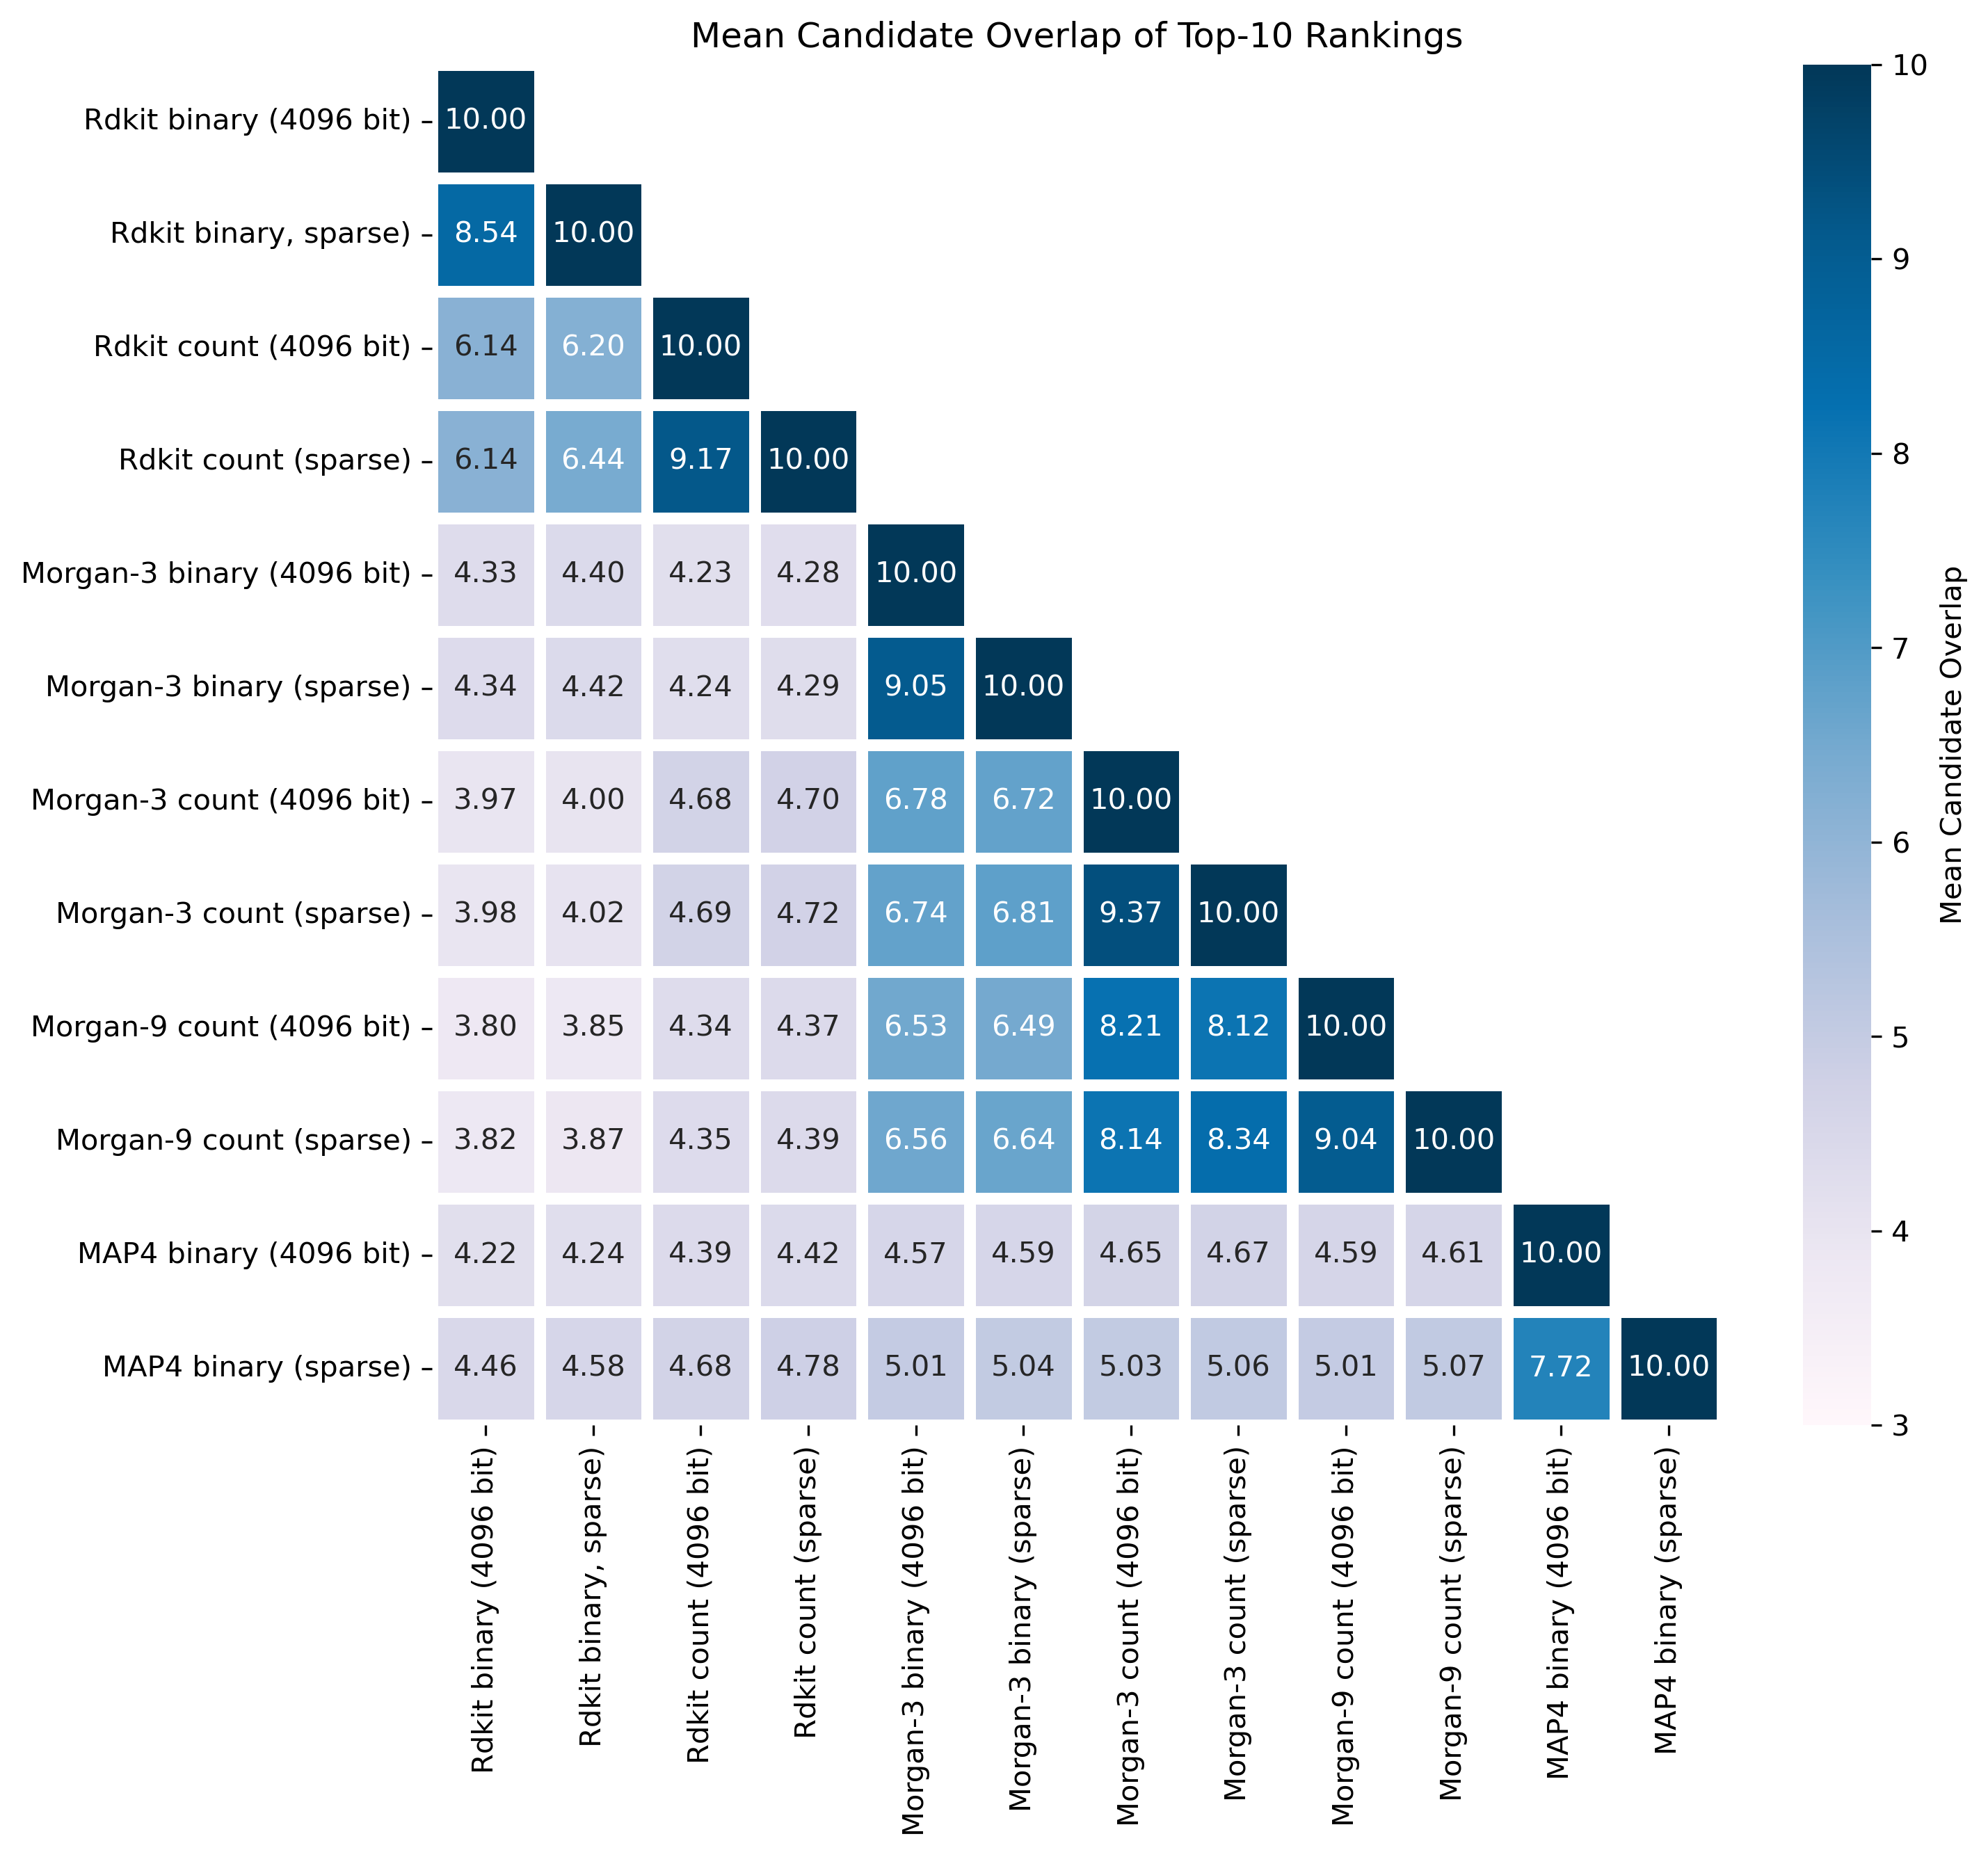

In [21]:
import seaborn

labels = ["Rdkit binary (4096 bit)",
          "Rdkit binary, sparse)",
          "Rdkit count (4096 bit)",
          "Rdkit count (sparse)",
          "Morgan-3 binary (4096 bit)",
          "Morgan-3 binary (sparse)",
          "Morgan-3 count (4096 bit)",
          "Morgan-3 count (sparse)",
          "Morgan-9 count (4096 bit)",
          "Morgan-9 count (sparse)",
          "MAP4 binary (4096 bit)",
          "MAP4 binary (sparse)",
         ]


nn1 = 10
nn2 = 10
#mask = np.tril(np.ones_like(overlap_matrix, dtype=bool), k=-1)
mask = np.triu(np.ones_like(overlap_matrix, dtype=bool), k=1)

# Set up the matplotlib figure.
plt.figure(figsize=(10, 9), dpi=300)

# Plot the heatmap.
seaborn.heatmap(overlap_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='PuBu',
            linewidths=4,  
            linecolor='white',
            vmin=3, 
            #vmax=10,
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Mean Candidate Overlap'})

#plt.title(f'Mean Overlap of Top-{nn1} and Top-{nn2} Rankings')
plt.title(f'Mean Candidate Overlap of Top-10 Rankings')
plt.tight_layout()
plt.savefig("Top10_overlaps_all_scores.png", dpi=450)
plt.savefig("Top10_overlaps_all_scores.pdf")
plt.show()

In [54]:
from rdkit import Chem
from rdkit.Chem import Draw


def show_top_n(scores, idx, nn=5):
    closest = np.argsort(scores[idx, :])[-nn:][::-1]
    smiles1 = compounds.smiles[idx]
    mols = [Chem.MolFromSmiles(smiles1)]
    
    labels = ["Query compound"]
    
    for index in closest:
        labels.append(f"Score: {scores[idx, index]:.4f}")
        mols.append(Chem.MolFromSmiles(compounds.smiles[index]))
    
    display(Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(800, 800), returnPNG=False, 
                         #labels=labels
                        ))

def compare_top_n(scores_list, idx, nn=5):
    for scores in scores_list:
        show_top_n(scores, idx, nn)

10237


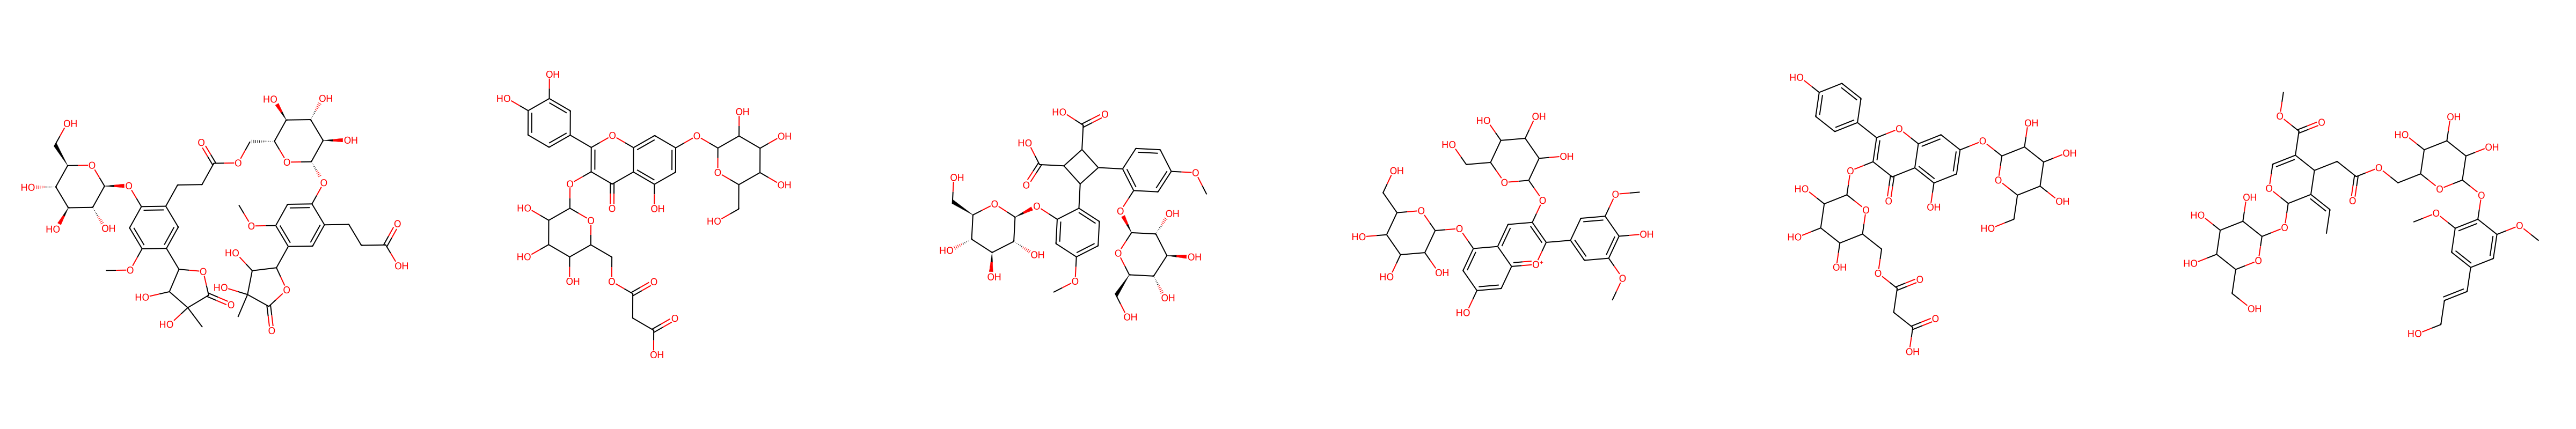

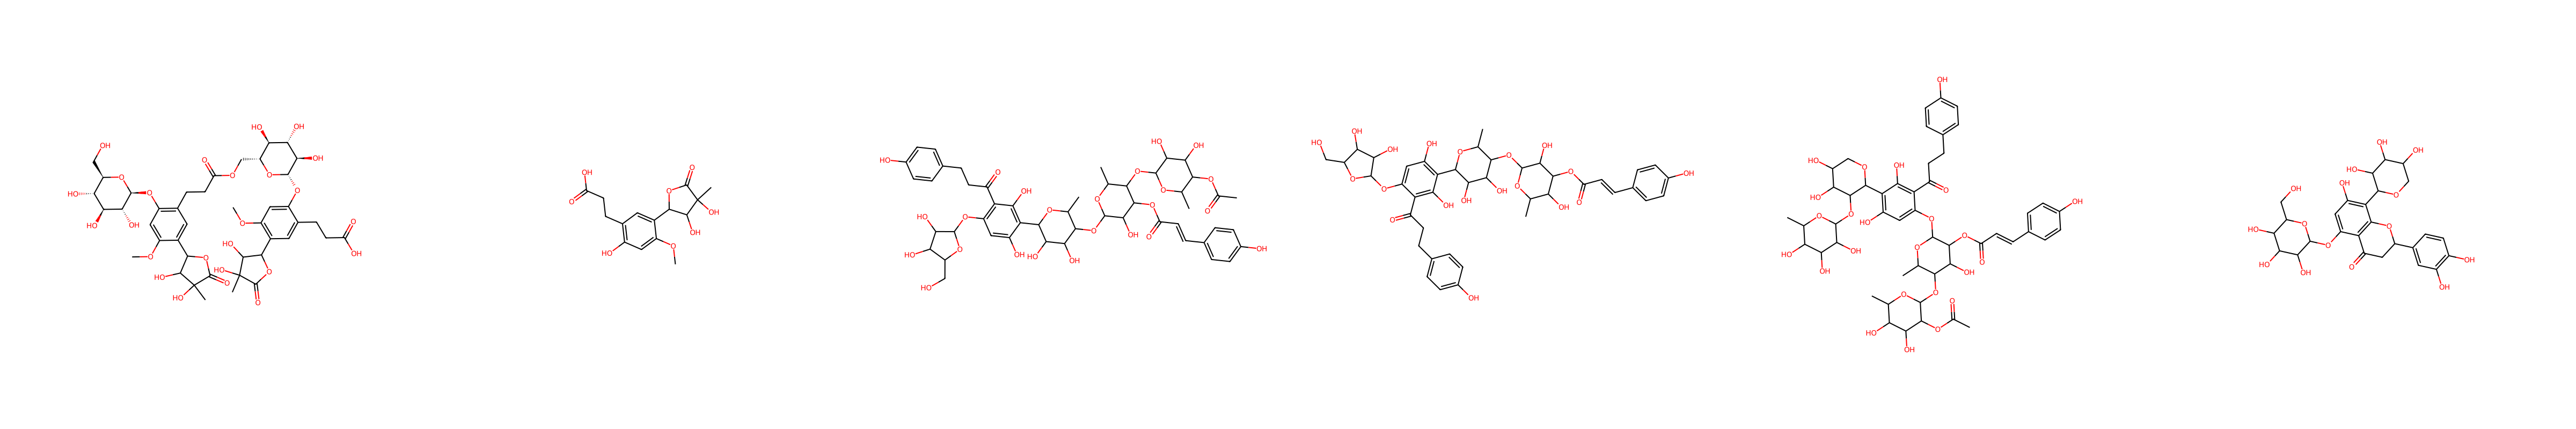

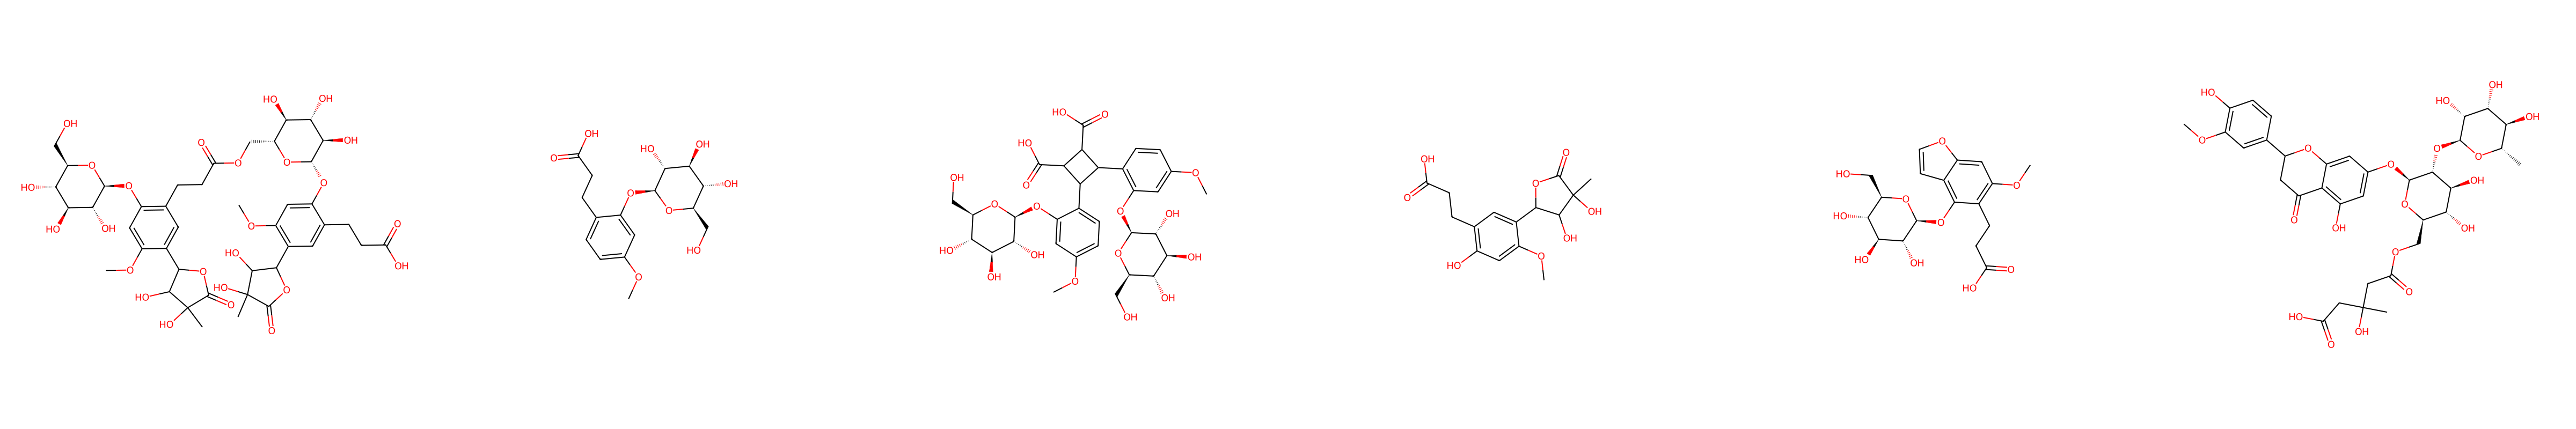

In [245]:
nn = 5
idx = little_overlap[109]  

# idx 54, 90, 122, 164, 177, 220, 319, 344, 464!, 486, 499, 525, 663, 741!, 867!, 37299 (count), 37109, 37078 (rdkit bad)
# 36920 (small mol), 36631 (map4 best), 35289 (morgan bad), 34355 (map4 bad), 8923 (large), 10237 (count)

#idx = 741
print(idx)

compare_top_n(
    [scaled_similarities_morgan3_count_sparse,
     scaled_similarities_rdkit_sparse,
     scaled_similarities_map4_sparse
    ],
     idx)